In [1]:
# General
import os
import sys
import shutil
import posixpath
import warnings
import importlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# SciPy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import periodogram, butter, filtfilt

# Gpflow & tensorflow
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *

# Files
import csv
import pandas as pd
import seaborn as sns
import wfdb
from scipy.io import loadmat  # this is the SciPy module that loads mat-files

# Local scripts
#sys.path.insert(0, '/home/david/Documenten/Courses/Spectral Discontinuity Design/Thesis AI/Implementation/')
sys.path.insert(0, os.chdir(".."))
from SpectralMixture import SpectralMixture, initialize_from_emp_spec
import toolbox as t
from bnqdflow import models, base, effect_size_measures, util, analyses

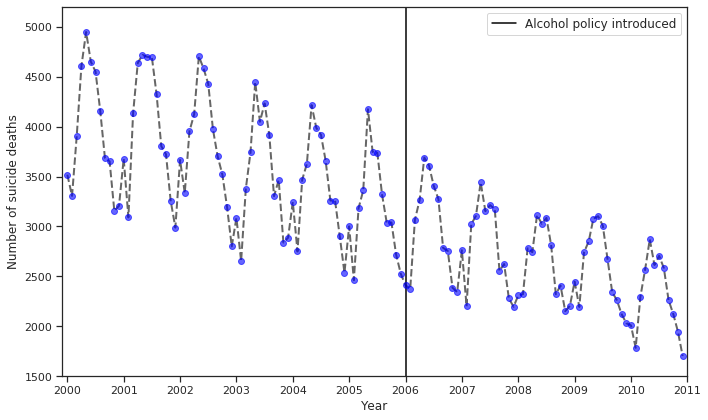

In [5]:
# load in data
sns.set(style='ticks')
x = np.arange(2000, 2011, step=1/12)
y = pd.read_csv("Implementation/datasets/Russian Suicide ITS/RussianSuicideITS.csv")
y = y['0'].to_numpy()

b = 2006 
n = len(x)
fs = 12
nyquist = fs/2

fig, ax = plt.subplots(1,1,figsize=(10,6)) #plt.figure(figsize=(14,8))
ax.axvline(b, color='black',label='Alcohol policy introduced')
ax.plot(x,y,alpha=0.6,
         color='black',linestyle='dashed',linewidth=2,
         marker='o',markersize=6,markerfacecolor='blue',
         markeredgecolor='blue')# plt.plot(X,Y)
ax.set_ylim((1500, 5200))
ax.set_xlim((1999.9,2011))
ax.set_xticks([y for y in range(2000,2012,1)])
ax.set_yticks([y for y in range(1500,5100, 500)])
ax.set_xlabel('Year')
ax.set_ylabel('Number of suicide deaths')
#ax.set_title("Monthly male suicide deaths: Russia, 2000–2010.",fontsize=30,y=1.05)
plt.legend(prop={'size': 12},loc='best')
plt.tight_layout()
#plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/Russian Suicide ITS/data.pdf',dpi=400)
plt.show()

3.175335357031016


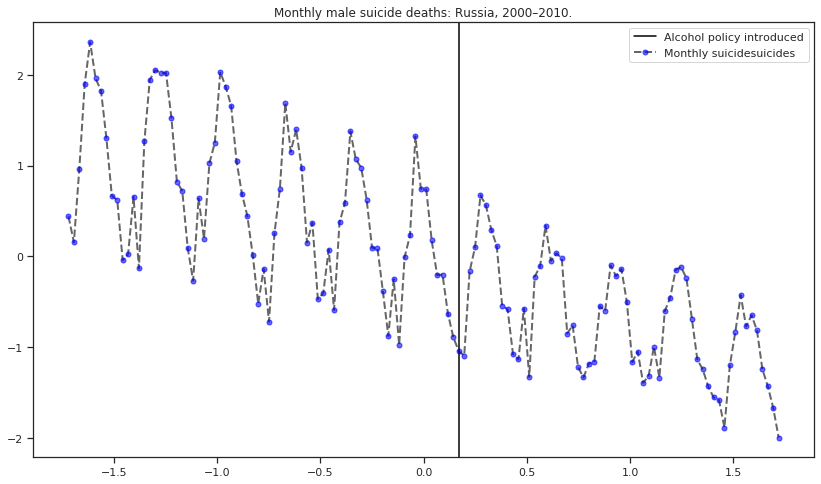

In [6]:
# Standardize data
zscorey = lambda a,y: (a - np.mean(y)) / np.std(y)
zscorex = lambda a,x: (a - np.mean(x)) / np.std(x)
print(np.std(x))
Y = zscorey(y,y)
B = zscorex(b,x)
X = zscorex(x,x)
# B = b
# X = x
xx = np.linspace(min(X),max(X),n*5)

# Data used by the control model and intervention model
x1, x2      = X[X <= B,], X[X>B,]
y1, y2      = Y[X <= B,], Y[X>B,]
xx1, xx2    = xx[xx <= 0.], xx[xx > 0.]
data        = [(x1, y1), (x2, y2)]

# plot normalized data
fig, ax = plt.subplots(1,1,figsize=(14,8)) #plt.figure(figsize=(14,8))
ax.axvline(B, color='black',label='Alcohol policy introduced')
ax.plot(X,Y,alpha=0.6,label='Monthly suicidesuicides',
         color='black',linestyle='dashed',linewidth=2,
         marker='o',markersize=5,markerfacecolor='blue',
         markeredgecolor='blue')# plt.plot(X,Y)
ax.set_title("Monthly male suicide deaths: Russia, 2000–2010.")
plt.legend()
plt.show()

In [7]:
# Kernels

colours_prior   = ['#1a1835', '#15464e', '#2b6f39', '#757b33', '#c17a70', '#d490c6', '#c3c1f2', '#cfebef']

# Spectral Mixture
max_length      = 1.0
max_freq        = 2 * np.pi
Q               = 2 # t.find_optimal_Q(X, Y, min_Q=1, max_Q=5, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
sm              = SpectralMixture(Q, max_length=max_length, max_freq=max_freq) 
damped_periodic = SquaredExponential(lengthscales=10.)*Periodic(SquaredExponential(lengthscales=0.1),period=3)
periodic        = Periodic(SquaredExponential(lengthscales=.1),period=3.)


Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [8]:
# Plotting parameters
padding           = 0.5
ylim              = (-4.7,5.2)#(-2.5,2.3)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
╒════════════════════════════════════════════════════════════╤═══════════╤════════════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                                       │ class     │ transform              │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════════════════════════════╪═══════════╪══

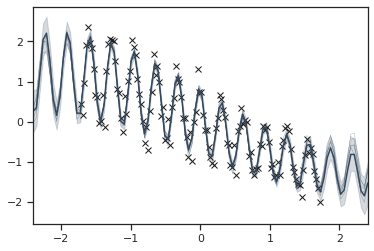

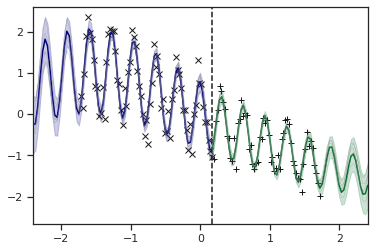

In [11]:
# Run analysis
a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, B, share_params=False)
a.train(verbose=True)
log_bayes_factor = a.log_bayes_factor(verbose=False)
print('Log bayes factor: ', log_bayes_factor.numpy())
a.plot_regressions()
# e_with_weight = t.EffectSizeGMM(a)
# e_KL = t.EffectSizeGMM(a, mode='KullbackLeibler')
# print('Difference ffect size: ', e_with_weight)
# print('Kullback-Leibler effect size: ', e_KL)


# print('\nControl')
# ml_solutions_control = []
# ml_solutions_intervention = []

# for kernel in a.discontinuous_model.models[0].kernel.kernels:
#     ml_solutions_control.append((kernel.mixture_weight.numpy(),kernel.frequency.numpy(),kernel.lengthscale.numpy() ))
#     print('Index: ', kernel.index, '. Frequency: ',
#         round(kernel.frequency.numpy(), 3), 'lengthscale: ', round(kernel.lengthscale.numpy(),3),
#         'mixture weight: ', round(kernel.mixture_weight.numpy(),3))
# print('intervention')
# for kernel in a.discontinuous_model.models[1].kernel.kernels:
#     ml_solutions_intervention.append((kernel.mixture_weight.numpy(),kernel.frequency.numpy(),kernel.lengthscale.numpy() ))

#     print('Index: ', kernel.index, '. Frequency: ',
#         round(kernel.frequency.numpy(), 3), 'lengthscale: ', round(kernel.lengthscale.numpy(),3),
#         'mixture weight: ', round(kernel.mixture_weight.numpy(),3))

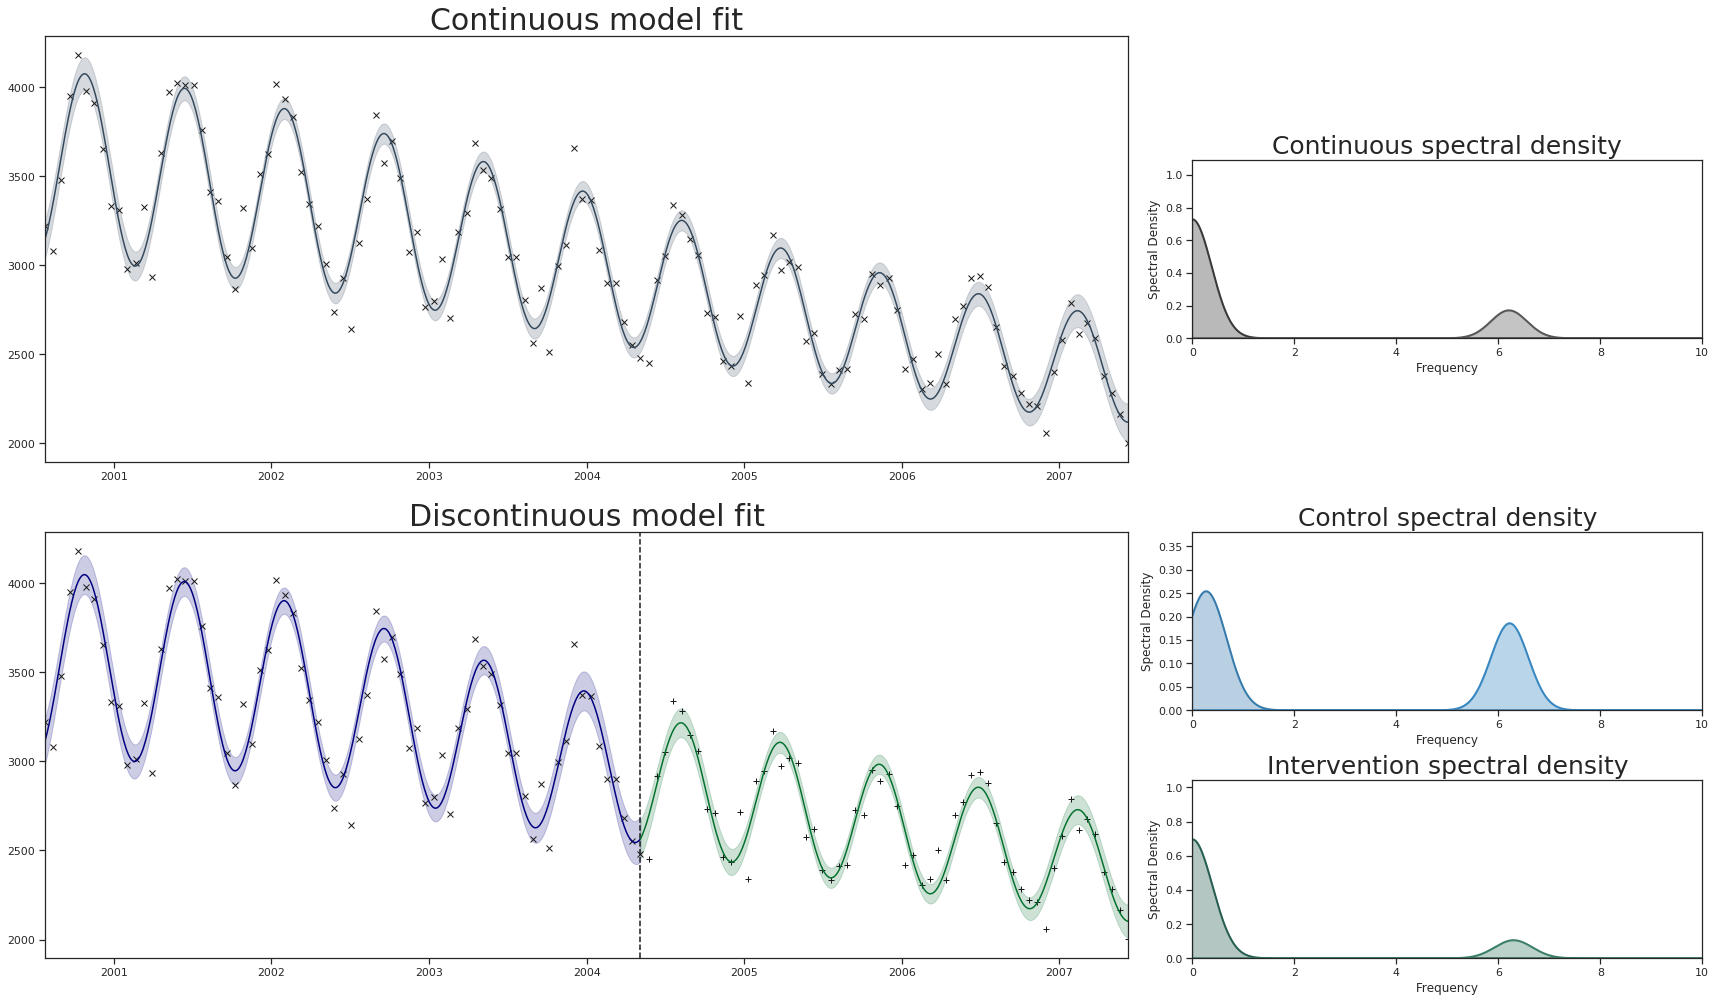

In [12]:
# Plot results
t.plot_posterior_model_spectrum(a, Q, padding=0,max_x = 10,scalar=2*np.pi/np.std(x),xticks=[y for y in range(2000,2012,1)],yticks=[y for y in range(1500,5100, 500)])
#plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/Russian Suicide ITS/MAP_estimates.pdf',dpi=400)
plt.show()

In [8]:
print(1/np.std(x))

0.31492736595073045


In [9]:
# Plot results
t.plot_synthetic_control_posterior_spectrum(a, Q, padding=0, max_x = (max_freq/(2*np.pi)),lineplot=False,scalar=(2*np.pi)/np.std(x))
#plt.savefig('ecg_test_result_MAP_oldindices_lineplot')
plt.show()


AttributeError: module 'toolbox' has no attribute 'plot_synthetic_control_posterior_spectrum'

# HMC Stuff

In [ ]:
# Run HMC control
import time
start = time.time()
gpflow.set_trainable(a.discontinuous_model.models[0].likelihood.variance, False)
combined_param_samples_control = t.HMC(m=a.discontinuous_model.models[0], n_burnin_steps=50, n_samples=10000, n_chains=4, step_size = 0.05)
end = time.time()
print('sampling duration: ', end - start)
#kernels_control = t.kernel_density_estimation(combined_param_samples_control)
print(time.time()-end )

In [ ]:
# Run HMC intervention
import time
start = time.time()
gpflow.set_trainable(a.discontinuous_model.models[1].likelihood.variance, False)
combined_param_samples_intervention = t.HMC(m=a.discontinuous_model.models[1], n_burnin_steps=50, n_samples=10000, n_chains=4, step_size = 0.05)
end = time.time()
print('sampling duration: ', end - start)
#kernels_control = t.kernel_density_estimation(combined_param_samples_control)
print(time.time()-end )

In [ ]:
import csv
import pickle

def save_csv(fname, kernels, mode='log_dens'):
    fname_samples = 'control_samples_output.csv'
    with open(fname_samples, 'w', newline='') as f:
        writer = csv.writer(f)
        for (_, log_dens, samples)  in kernels:
            if mode=='log_dens':
                writer.writerow(log_dens)
            elif mode=='samples':
                writer.writerow(samples)
            else:
                print('Mode misspecified')
                
def save_pkl(fname, kernels):
    with open(fname, 'wb') as output:
        for (kde, _, _)  in kernels:
            pickle.dump(kde, output, pickle.HIGHEST_PROTOCOL)    
            
def load_csv(fname, mode='log_dens'):
    param_samples = []
    with open(fname, 'r', newline='') as f:
        reader = csv.reader(f)
        for samples in reader:
            if mode=='log_dens':
                param_samples.append(np.array(samples).astype(float))
            elif mode=='samples':
                param_samples.append(np.array(samples).astype(float))
            else:
                print('Mode misspecified')
    return param_samples
            
def load_pkl(fname, N):
    with open(fname, 'rb') as input:
        kde = []
        for i in range(1): 
            kde_param = pickle.load(input)
            print(kde_param)
            print(len(kde_param))
            kde.append(kde_param)
    return kde

In [ ]:
# To do for these figures on 7-7: add control / interventio ngroups. 
# Make new HMC samples, and plot them as pdf with dpi=400.

fig, ax = plt.subplots(2,4,figsize=(16,8),tight_layout=True)
bins = 40

# cols = [f'$d$ = {d}'.format(d) for d in discontinuity_sizes]
rows = ['{}'.format(row) for row in ['Control', 'Intervention']]
pad = 5 # in points
cols = ['Component 1', 'Component 2']


ax[0,0].annotate(cols[0], xy=(0.5, 1.08), xytext=(0, pad),  xycoords='axes fraction', textcoords='offset points',
            fontsize=18, ha='center', va='baseline')
ax[0,2].annotate(cols[1], xy=(0.5, 1.08), xytext=(0, pad),  xycoords='axes fraction', textcoords='offset points',
            fontsize=18, ha='center', va='baseline')   
for ax_x, row in zip(ax[:,0], rows):
    ax_x.annotate(row, xy=(0, 0.5), xytext=(-ax_x.yaxis.labelpad - pad, 0),
               xycoords=ax_x.yaxis.label, textcoords='offset points',
                fontsize=16, ha='right', va='center')

j = 0
hls = sns.cubehelix_palette(9, rot=-.25, light=.7)
blues = hls.as_hex()[3:]

for i, samples in enumerate(combined_param_samples_control):
    (ml_weight, ml_freq, ml_lengthscale) = ml_solutions_control[int(i/3)]
    
    # Frequency
    if i%3==0:
        samples = samples / (2*np.pi*np.std(x))
        ml_freq = ml_freq / (2*np.pi*np.std(x))        
        ax[0,j].get_shared_y_axes().join(ax[0,j], ax[1,j])
        ax[0,j].get_shared_x_axes().join(ax[0,j], ax[1,j])


        ax[0, j].hist(np.stack(samples).flatten(), color=blues[j], bins=bins, density=True)
        #ax[0, j].axvline(x=ml_freq, color='black', linestyle=':',label='ML estimate')
        ax[0, j].set_ylabel('Samples (normalized)')

        ax[0, j].set_title(f'Frequency of component {1+int(i/3)}')

        j += 1
        
    # Mixture weight
    if i%3==2:
        ax[0,j].get_shared_y_axes().join(ax[0,j], ax[1,j])
        ax[0,j].get_shared_x_axes().join(ax[0,j], ax[1,j])
        ax[0, j].hist(np.stack(samples).flatten(),color=blues[j],bins=bins, range=[0,10],density=True)
        #ax[0, j].axvline(x=ml_weight, color='black', linestyle=':',label='ML estimate')
        ax[0, j].set_ylabel('Samples (normalized)')

        ax[0, j].set_title(f'Weight of component {1+int(i/3)}')
        j += 1
        #ax[0,0].legend()

    

# Intervention
hls = sns.cubehelix_palette(9, rot=-.45)
greens = hls.as_hex()[2:]
j=0
for i, samples in enumerate(combined_param_samples_intervention):
    (ml_weight,ml_freq,ml_lengthscale) = ml_solutions_intervention[int(i/3)]
    # Frequency
    if i%3==0:
        samples = samples / (2*np.pi*np.std(x))
        ml_freq = ml_freq / (2*np.pi*np.std(x))
        ax[1, j].hist(np.stack(samples).flatten(), color=greens[j], bins=bins, density=True)
        #ax[1, j].axvline(x=ml_freq, color='black', linestyle=':',label='ML estimate')
        #ax[1, j].set_ylim(0,3)
        ax[1, j].set_ylabel('Samples (normalized)')
        ax[1, j].set_title(f'Frequency of component {1+int(i/3)}')
        j+=1
    
#     # Lengthscale
#     if i%3==2:
#         ax[1, j].hist(np.stack(samples).flatten(), color=greens[j],bins=bins)
#         ax[1, j].axvline(x=ml_lengthscale, color='black', linestyle=':',label='ML estimate')
#         ax[1, j].set_title(f'Lengthscale of component {1+int(i/3)}')
#         j+=1
            
    
    # Mixture weight
    if i%3==2:
        ax[1, j].hist(np.stack(samples).flatten(), color=greens[j],bins=bins, range=[0,10],density=True)
        #ax[1, j].axvline(x=ml_weight, color='black', linestyle=':',label='ML estimate')
        ax[1, j].set_ylabel('Samples (normalized)')

        ax[1, j].set_title(f'Weight of component {1+int(i/3)}')
        j+=1
        
    
    #ax[1,j-1].legend()
#plt.savefig('Russian_alcohol_HMC_samples')
plt.show()

In [ ]:
# ## Compute model evidence

# # For each sample (in all dimensions), compute marginal likelihood
# # samples = (n_param*n_chains, n_samples)

# likelihoods = 0
# # Loop over chains
# for n_chain in range(4):
#     for n_samples in range(10000):
#         lengthscales = ... #(2,)
#         weights = ...     #(2,)
#         frequencies = .. # (2,)
#         sm = SpectralMixture(Q=2, mixture_weights, frequencies, lengthscales)
#         m = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
#         log_marginal_likelihood = m.log_marginal_likelihood()
#         likelihoods += log_marginal_likelihood
#     print('chain done')

# #Integrate out over all the samples
# print('Sum log likelihoods: ', )
# print('Average log likelihood', likelihoods/40000)

In [ ]:
fig, ax = plt.subplots(2,6,figsize=(16,8),tight_layout=True)
bins = 40

j = 0
hls = sns.cubehelix_palette(9, rot=-.25, light=.7)
blues = hls.as_hex()[3:]

for i, samples in enumerate(combined_param_samples_control):
    (ml_weight, ml_freq, ml_lengthscale) = ml_solutions_control[int(i/3)]
    
    # Frequency
    if i%3==0:
        samples = samples / (2*np.pi*np.std(x))
        ml_freq = ml_freq / (2*np.pi*np.std(x))        
        ax[0,j].get_shared_y_axes().join(ax[0,j], ax[1,j])
        ax[0,j].get_shared_x_axes().join(ax[0,j], ax[1,j])


        ax[0, j].hist(np.stack(samples).flatten(), color=blues[j], bins=bins, density=True)
        ax[0, j].axvline(x=ml_freq, color='black', linestyle=':',label='ML estimate')
        ax[0, j].set_ylabel('Samples (normalized)')

        ax[0, j].set_title(f'Frequency of component {1+int(i/3)}')

        j += 1
    if i%3==1:
        ax[1, j].hist(np.stack(samples).flatten(), color=greens[j],bins=bins)
        ax[1, j].axvline(x=ml_lengthscale, color='black', linestyle=':',label='ML estimate')
        ax[1, j].set_title(f'Lengthscale of component {1+int(i/3)}')
        j+=1
        
    # Mixture weight
    if i%3==2:
        ax[0,j].get_shared_y_axes().join(ax[0,j], ax[1,j])
        ax[0,j].get_shared_x_axes().join(ax[0,j], ax[1,j])
        ax[0, j].hist(np.stack(samples).flatten(),color=blues[j],bins=bins, range=[0,10],density=True)
        ax[0, j].axvline(x=ml_weight, color='black', linestyle=':',label='ML estimate')
        ax[0, j].set_ylabel('Samples (normalized)')

        ax[0, j].set_title(f'Weight of component {1+int(i/3)}')
        j += 1
        #ax[0,0].legend()

    

# Intervention
hls = sns.cubehelix_palette(9, rot=-.45)
greens = hls.as_hex()[2:]
j=0
for i, samples in enumerate(combined_param_samples_intervention):
    (ml_weight,ml_freq,ml_lengthscale) = ml_solutions_intervention[int(i/3)]
    # Frequency
    if i%3==0:
        samples = samples / (2*np.pi*np.std(x))
        ml_freq = ml_freq / (2*np.pi*np.std(x))
        ax[1, j].hist(np.stack(samples).flatten(), color=greens[j], bins=bins, density=True)
        ax[1, j].axvline(x=ml_freq, color='black', linestyle=':',label='ML estimate')
        #ax[1, j].set_ylim(0,3)
        ax[1, j].set_ylabel('Samples (normalized)')
        ax[1, j].set_title(f'Frequency of component {1+int(i/3)}')
        j+=1
    
#     # Lengthscale
    if i%3==1:
        ax[1, j].hist(np.stack(samples).flatten(), color=greens[j],bins=bins)
        ax[1, j].axvline(x=ml_lengthscale, color='black', linestyle=':',label='ML estimate')
        ax[1, j].set_title(f'Lengthscale of component {1+int(i/3)}')
        j+=1
            
    
    # Mixture weight
    if i%3==2:
        ax[1, j].hist(np.stack(samples).flatten(), color=greens[j],bins=bins, range=[0,10],density=True)
        ax[1, j].axvline(x=ml_weight, color='black', linestyle=':',label='ML estimate')
        ax[1, j].set_ylabel('Samples (normalized)')

        ax[1, j].set_title(f'Weight of component {1+int(i/3)}')
        j+=1
        
    
    #ax[1,j-1].legend()
#plt.savefig('Russian_alcohol_HMC_samples.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(24,6))
ax = ax.ravel()

j = 0
for i in range(6):
    # frequency
    if i%3==0:
        if i ==0:
            ax[j].set_ylim(0,0.1)
            ax[j].set_xlim(0,0.1)
        if i == 3:
            ax[j].set_ylim(0.95,1.05)
            ax[j].set_xlim(0.95,1.05)
        control_samples = combined_param_samples_control[i] / (2*np.pi*np.std(x))
        intervention_samples = combined_param_samples_intervention[i] / (2*np.pi*np.std(x))
        ax[j].hexbin(control_samples, intervention_samples, bins=40)
        ax[j].set_title(f'Frequency of component {int(i/3)}')
        sns.jointplot(combined_param_samples_control[i] , combined_param_samples_intervention[i], kind="kde")#, color="#4CB391")
        j+=1

#     if i%3==1:
#         continue
#         control_samples = combined_param_samples_control[i]
#         intervention_samples = combined_param_samples_intervention[i]
#         ax[i].hist2d(control_samples, intervention_samples, bins=40)
#         ax[i].set_title(f'Lengthscale of component {int(i/3)}')

    # Mixture weight
    if i%3==2:
        control_samples = combined_param_samples_control[i]
        intervention_samples = combined_param_samples_intervention[i]
        ax[j].hexbin(control_samples, intervention_samples, bins=40,cmap=cm.magma)
        sns.jointplot(control_samples ,intervention_samples, kind="hex", color="#4CB391")

        ax[j].set_title(f'Weights of component {int(i/3)}')
        j+=1

plt.show()

In [ ]:
# Frequency
control_freq_samples = np.concatenate([combined_param_samples_control[0],combined_param_samples_control[3]])
intervention_freq_samples = np.concatenate([combined_param_samples_intervention[0],combined_param_samples_intervention[3]])
sns.jointplot(control_freq_samples/ (2*np.pi*np.std(x)), intervention_freq_samples/ (2*np.pi*np.std(x)), kind="kde", color="#4CB391").set_axis_labels("Control frequency samples", "Intervention frequency samples")

# Lengthscale
control_lengthscale_samples = np.concatenate([combined_param_samples_control[1],combined_param_samples_control[4]])
intervention_lengthscale_samples = np.concatenate([combined_param_samples_intervention[1],combined_param_samples_intervention[4]])
sns.jointplot(control_lengthscale_samples, intervention_lengthscale_samples, kind="kde").set_axis_labels("Control lengthscale samples", "Intervention lengthscale samples")

# Mixture weight
control_weight_samples = np.concatenate([combined_param_samples_control[2],combined_param_samples_control[5]])
intervention_weight_samples = np.concatenate([combined_param_samples_intervention[2],combined_param_samples_intervention[5]])
sns.jointplot(control_weight_samples, intervention_weight_samples, kind="kde",color='r').set_axis_labels("Control weight samples", "Intervention weight samples")


In [ ]:
# Frequency
control_frequency1_samples = combined_param_samples_control[0]
intervention_frequency1_samples = combined_param_samples_intervention[0]
sns.jointplot(control_frequency1_samples, intervention_frequency1_samples, kind="hex",color="#4CB391").set_axis_labels("Control frequency component 1", "Intervention lengthscale component 1")

control_frequency2_samples = combined_param_samples_control[3]
intervention_frequency2_samples = combined_param_samples_intervention[3]
sns.jointplot(control_frequency2_samples, intervention_frequency2_samples, kind="hex",color="#4CB391").set_axis_labels("Control lengthscale component 2", "Intervention lengthscale component 2")


# Lengthscale
control_lengthscale1_samples = combined_param_samples_control[1]
intervention_lengthscale1_samples = combined_param_samples_intervention[1]
sns.jointplot(control_lengthscale1_samples, intervention_lengthscale1_samples, kind="hex",color='b').set_axis_labels("Control lengthscale component 1", "Intervention lengthscale component 1")

control_lengthscale2_samples = combined_param_samples_control[4]
intervention_lengthscale2_samples = combined_param_samples_intervention[4]
sns.jointplot(control_lengthscale2_samples, intervention_lengthscale2_samples, kind="hex",color='b').set_axis_labels("Control lengthscale component 2", "Intervention lengthscale component 2")

# Weight
control_weight_samples = combined_param_samples_control[2]
intervention_weight_samples = combined_param_samples_intervention[2]
sns.jointplot(control_weight_samples, intervention_weight_samples, kind="hex",color='r').set_axis_labels("Control weight component 1", "Intervention weight component 1")

control_weight2_samples = combined_param_samples_control[5]
intervention_weight2_samples = combined_param_samples_intervention[5]
sns.jointplot(control_weight2_samples, intervention_weight2_samples, kind="hex",color='r').set_axis_labels("Control weight component 2", "Intervention weight component 2")


In [ ]:
control_frequency2_samples = combined_param_samples_control[3]
intervention_frequency2_samples = combined_param_samples_intervention[3]
sns.jointplot(control_frequency2_samples/(2*np.pi*np.std(x)), intervention_frequency2_samples/(2*np.pi*np.std(x)), kind="hex",color="#4CB391").set_axis_labels("Control frequency component 2", "Intervention frequency component 2")
plt.tight_layout()
#plt.savefig('Russian_frequency2_jointplot.png')

# Mixture weight
control_weight2_samples = combined_param_samples_control[5]
intervention_weight2_samples = combined_param_samples_intervention[5]
sns.jointplot(control_weight2_samples, intervention_weight2_samples, kind="hex",color='b').set_axis_labels("Control weight component 2", "Intervention weight component 2")
plt.tight_layout()
#plt.savefig('Russian_weight2_jointplot.png')


In [ ]:
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

# number of parameters
N = 2*3 # len(kernels_control) 
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
freq_samples = []
# When running hmc
for i, (kde, log_dens, samples ) in enumerate(kernels_control):
    if i%3 is 0:
        #log_densities = kernel#[log_dens for i,(_,log_dens,samples) in enumerate(kernels) if i%3 is 0]
        xx = np.linspace(0, int(samples.max()), int(1000*samples.max())+1)
        freq_samples.append((log_dens,xx))

# # When loading in data
# for i in range(N):
#     if i%3 is 0:
#         samples = samples_control[i]
#         max_val = max(samples)
#         log_dens = log_dens_control[i]
#         xx = np.linspace(0, int(max_val), int(1000*max_val)+1)
#         freq_samples.append((log_dens,xx))

hls = sns.cubehelix_palette(len(freq_samples), rot=-.25, light=.7)
sns.palplot(hls)
blues = hls.as_hex()

gs = grid_spec.GridSpec(N,1)
fig = plt.figure(figsize=(8, 8))


ax_objs = []
for i, (log_dens,xx) in enumerate(freq_samples):
    
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    xlim=21
    ax_objs[-1].plot(xx, np.exp(log_dens),color="black",lw=1)
    ax_objs[-1].plot(np.arange(0,xlim), [0 for i in range(xlim)], color='black')
    ax_objs[-1].fill_between(xx, np.exp(log_dens), alpha=0.7,color=blues[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,xlim)
    ax_objs[-1].set_ylim(0,0.9)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == N-1:
        ax_objs[-1].set_xlabel("Frequency", fontsize=16)
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.2,0,i+1,fontsize=14,ha="right")


gs.update(hspace=-0.7)

fig.text(0.07,0.85,"HMC samples of frequency for every component",fontsize=20)

plt.tight_layout()
plt.savefig('Plots/initial_control_HMC_plot_nameunpsecifiedyet.png')
plt.show()

In [ ]:
# Run periodic analysis
periodic = Periodic(SquaredExponential(lengthscales=0.1),period=3.1)
a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], periodic, B, share_params=False)
a.train(verbose=False)
t.plot_posterior_model_spectrum(a, Q, padding=0, max_x = (max_freq/(2*np.pi)),lineplot=False)

log_bayes_factor = a.log_bayes_factor(verbose=False)
print('Log bayes factor: ', log_bayes_factor.numpy())
a.plot_regressions()

In [ ]:
# Run damped periodic analysis
damped_periodic = SquaredExponential(lengthscales=10.)*Periodic(SquaredExponential(lengthscales=0.1),period=3)
a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], damped_periodic, B, share_params=False)
a.train(verbose=False)
t.plot_synthetic_control_posterior_spectrum(a, Q, padding=0, max_x = (max_freq/(2*np.pi)),lineplot=False)

log_bayes_factor = a.log_bayes_factor(verbose=False)
print('Log bayes factor: ', log_bayes_factor.numpy())
a.plot_regressions()